In [1]:

import tensorflow as tf
import os
from tensorflow import keras
import numpy as np
import os
import tqdm
import sys

tf.random.set_seed(1)

VERSION = '6'
OUTPUT_DIR = "v"+VERSION+"_fer2013_OUTPUT"
SAVE_IMGS = False
EXTRACT_IMGS = False
GOOGLE_COLAB = False
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)
print("Mevcut kullanılabilir GPU adedi : ", len(tf.config.list_physical_devices('GPU')))

v6_fer2013_OUTPUT
Mevcut kullanılabilir GPU adedi :  1


In [2]:
if GOOGLE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:


if EXTRACT_IMGS:
  if GOOGLE_COLAB:
    !pip install zipfile36
    if sys.version_info >= (3, 6):
        import zipfile
    else:
        import zipfile36 as zipfile

    with zipfile.ZipFile("drive/MyDrive/archive.zip", 'r') as zObject:

        # Extracting all the members of the zip
        # into a specific location.
        zObject.extractall(
            path="fer2013")
  # Run through fer2013 dataset
  TEST_DIR= "fer2013/test"
  TRAIN_DIR = "fer2013/train"

  TRAIN_IMAGES = []
  TEST_IMAGES = []

  for emotion_dir in tqdm.tqdm(os.listdir(TRAIN_DIR)):

      for image in os.listdir(os.path.join(TRAIN_DIR, emotion_dir)):

          img = keras.preprocessing.image.load_img(os.path.join(TRAIN_DIR, emotion_dir, image),color_mode="grayscale")
          img = keras.preprocessing.image.img_to_array(img)
          TRAIN_IMAGES.append(img)

  for emotion_dir in tqdm.tqdm(os.listdir(TEST_DIR)):

      for image in os.listdir(os.path.join(TEST_DIR, emotion_dir)):

          img = keras.preprocessing.image.load_img(os.path.join(TEST_DIR, emotion_dir, image),color_mode="grayscale")
          img = keras.preprocessing.image.img_to_array(img)

          TEST_IMAGES.append(img)
  #print train shape
  print("Train shape : ", np.array(TRAIN_IMAGES).shape)
  print("Test shape : ", np.array(TEST_IMAGES).shape)

  ALL_IMAGES = np.concatenate([TRAIN_IMAGES, TEST_IMAGES])
  print("All images shape : ", ALL_IMAGES.shape)
  np.save("all_images.npy",ALL_IMAGES)
else:
  ALL_IMAGES = np.load("all_images.npy")



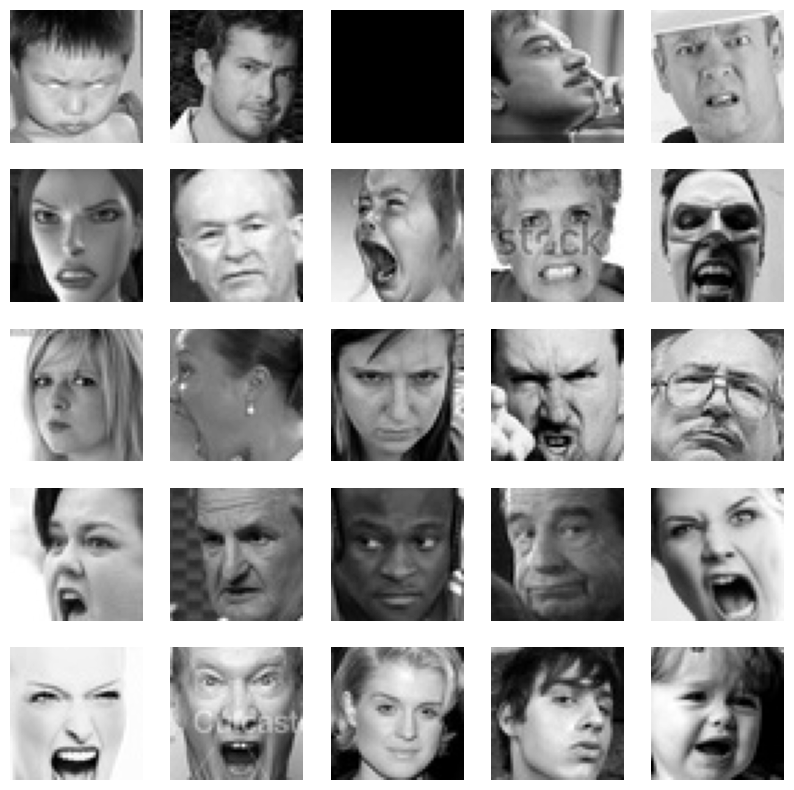

In [4]:
#plot first 25 images as image
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(ALL_IMAGES[i].reshape(48,48),cmap='gray')
    plt.axis('off')
plt.show()

In [5]:
import numpy as np
from skimage.color import rgb2gray

#merge the training and testing sets
dataset = ALL_IMAGES
#normalize the images 0 - 255 -> 0 - 1
dataset= (dataset.astype("float32")-127.5)/127.5
print(dataset.shape)
#3 kanal yerine -> 1 kanal
# dataset = rgb2gray(dataset)
# print(dataset.shape)
#reshape the images
# dataset = dataset.reshape(-1, 32, 32, 1)
# print(dataset.shape)


(35887, 48, 48, 1)


In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from keras import layers
import time

from IPython import display

In [7]:
BATCH_SIZE = 64

print("Datasetin boyutu : ", dataset.shape)

dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(60000).batch(BATCH_SIZE)
dataset


Datasetin boyutu :  (35887, 48, 48, 1)


<BatchDataset element_spec=TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None)>

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_57 (Conv2D  (None, 1, 1, 256)        409600    
 Transpose)                                                      
                                                                 
 batch_normalization_46 (Bat  (None, 1, 1, 256)        1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 1, 1, 256)         0         
                                                                 
 conv2d_transpose_58 (Conv2D  (None, 2, 2, 256)        1048576   
 Transpose)                                                      
                                                                 
 batch_normalization_47 (Bat  (None, 2, 2, 256)        1024      
 chNormalization)                                    

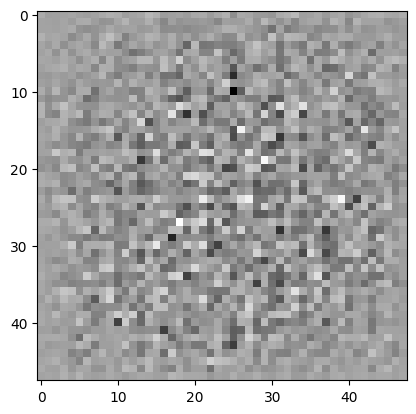

In [19]:
NOISE_DIM = 100
nfeats = 32
def make_generator_model():
    model = tf.keras.Sequential()
    # model.add(layers.Dense(4*4*1792, use_bias=False, input_shape=(NOISE_DIM,)))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.Reshape((4, 4, 1792)))

    model.add(layers.Conv2DTranspose(nfeats * 8, (4, 4), strides=(1, 1), padding="same",use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(nfeats * 8, (4, 4), strides=(2, 2), padding="same",use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(nfeats * 4, (4, 4), strides=(2, 2), padding="same",use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(nfeats * 4, (4, 4), strides=(2, 2), padding="same",use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(nfeats * 2, (4, 4), strides=(2, 2), padding="same",use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(nfeats , (4, 4), strides=(3, 3), padding="same",use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding="same",use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()
generator.build(input_shape=(None, 1,1,NOISE_DIM))
generator.summary()
noise = tf.random.normal([1, 1,1,NOISE_DIM])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [24]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(nfeats, (4, 4), strides=(2, 2), padding='same',use_bias=False,
                                     input_shape=[48, 48, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(nfeats*2, (4,4), strides=(2, 2), padding='same',use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(nfeats*4, (4,4), strides=(2, 2), padding='same',use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(nfeats*8, (4,4), strides=(2, 2), padding='same',use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 24, 24, 32)        512       
                                                                 
 leaky_re_lu_62 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 64)        32768     
                                                                 
 leaky_re_lu_63 (LeakyReLU)  (None, 12, 12, 64)        0         
                                                                 
 dropout_11 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 6, 6, 128)       

Non-trainable params: 0
_________________________________________________________________
tf.Tensor([[1.5324895e-07]], shape=(1, 1), dtype=float32)


In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [26]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [27]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [29]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

In [30]:
EPOCHS = 20

num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

In [31]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 1,1,NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return {
        "gen_loss": gen_loss,
        "disc_loss": disc_loss,
        "gen_acc": tf.reduce_mean(tf.cast(fake_output > 0, tf.float32)),
        "disc_acc": (tf.reduce_mean(tf.cast(real_output > 0, tf.float32)) + tf.reduce_mean(tf.cast(fake_output < 0, tf.float32)) ) / 2,
    }

In [32]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if SAVE_IMGS:
     plt.savefig(OUTPUT_DIR+'/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [33]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    gen_acc_arr = []
    disc_acc_arr = []
    gen_loss_arr = []
    disc_loss_arr = []
    for image_batch in dataset:
      res = train_step(image_batch)
      gen_acc_arr.append(res["gen_acc"])
      disc_acc_arr.append(res["disc_acc"])
      gen_loss_arr.append(res["gen_loss"])
      disc_loss_arr.append(res["disc_loss"])
    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    print ('Epoch {}: gen_loss: {:.4f}, disc_loss: {:.4f}, gen_acc: {:.4f}, disc_acc: {:.4f}'.format(epoch + 1,
                                                                                                      np.mean(gen_loss_arr),
                                                                                                      np.mean(disc_loss_arr),
                                                                                                      np.mean(gen_acc_arr),
                                                                                                      np.mean(disc_acc_arr)))

    # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [34]:
train(dataset, EPOCHS)

ValueError: in user code:

    File "C:\Users\Thinkstation\AppData\Local\Temp\ipykernel_17212\935805151.py", line 6, in train_step  *
        generated_images = generator(noise, training=True)
    File "c:\Users\Thinkstation\.conda\envs\dari\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Thinkstation\.conda\envs\dari\lib\site-packages\keras\engine\input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_11" "                 f"(type Sequential).
    
    Input 0 of layer "conv2d_transpose_57" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (64, 100)
    
    Call arguments received by layer "sequential_11" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(64, 100), dtype=float32)
      • training=True
      • mask=None
